# Time Series Style Transfer

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from configs.SimulatedData import Proposed
from dataset.tf_pipeline import make_train_valid_dset
from datetime import datetime
import io
import json
import os
from utils.metric import signature_on_batch, signature_metric
import mlflow
from sklearn.decomposition import PCA


gpus = tf.config.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs.
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized.
    print(e)

2024-06-26 18:01:40.405033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 18:01:40.504335: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 18:01:41.130830: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2024-06-26 18:01:41.130889: W tensorflow/compiler/xla/stream_exec

1 Physical GPUs, 1 Logical GPUs


2024-06-26 18:01:42.402615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 18:01:43.135552: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22271 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:2d:00.0, compute capability: 8.6


In [2]:
config = Proposed()
date_str = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')

CONTENT_DATASET_PATH = "data/simulated_dataset/01 - Source Domain.h5"
# STYLE_DATASET_PATHS = ["data/simulated_dataset/output_noise/0.25.h5", "data/simulated_dataset/output_noise/0.75.h5"]
STYLE_DATASET_PATHS = ["data/simulated_dataset/time_shift/4.h5", "data/simulated_dataset/time_shift/10.h5"]

EXPERIMENT_NAME = f"{date_str} - Style Transfer Algorithm + Patch GAN"
SAVE_FOLDER = f"experiments_logs/{EXPERIMENT_NAME}"

SEQUENCE_LENGTH = config.sequence_lenght_in_sample
GRANUARITY = config.granularity
OVERLAP = config.overlap
BS = 20 # config.batch_size
VALID_BATCH_SIZE = 50
EPOCHS = 10 # config.epochs
NUM_SEQUENCE_TO_GENERATE = config.met_params.sequence_to_generate
N_SIGNAL= 7

STYLE_VECTOR_SIZE = 16
FEAT_WIENER = 2
N_SAMPLE_WIENER = SEQUENCE_LENGTH//4
NOISE_DIM= (N_SAMPLE_WIENER, FEAT_WIENER)
N_VALIDATION_SEQUENCE = 500
DISCR_STEP = 10
DISCR_THREASOLD = 0.9

L_STYLE_GENERATION= 0.01
L_RECONSTR= 0.1

L_CONTENT= 1
L_DIS= 1
TRIPLET_R = 1
L_TRIPLET= 1
L_REALNESS= 0.05
L_ADV=  0.05


BASE_DIR = f"logs/{EXPERIMENT_NAME}"
TRAIN_LOGS_DIR_PATH = f"{BASE_DIR}/train"
VALID_LOGS_DIR_PATH = f"{BASE_DIR}/valid"
GENERATION_LOG = f"{BASE_DIR}/Generations"
os.makedirs(GENERATION_LOG)
os.makedirs(SAVE_FOLDER)

In [3]:
# server_ip = "192.168.210.102"
# mlflow_port_number= "5001"

# mlflow.set_tracking_uri(f'http://{server_ip}:{mlflow_port_number}') 
# exp = mlflow.get_experiment_by_name("Style Transfer Algorithm")

# run = mlflow.start_run(run_name=date_str) 
# mlflow.tensorflow.autolog()

In [4]:
def save_configuration():
    d = {
        "content_dataset":CONTENT_DATASET_PATH,
        "style_datasets":STYLE_DATASET_PATHS,
        "SEQUENCE_LENGTH":SEQUENCE_LENGTH,
        "granularity":GRANUARITY,
        "overlap":OVERLAP,
        "epochs":EPOCHS,
        "batch_size":BS,
        "style_vector_size":STYLE_VECTOR_SIZE,
        "feat_wiener":FEAT_WIENER,
        "n_sample_wiener":N_SAMPLE_WIENER,
        "triplet_r":TRIPLET_R,
        "n_validation_sequence":N_VALIDATION_SEQUENCE,
        "l_style":L_STYLE_GENERATION,
        "l_content":L_CONTENT,
        "l_triplet":L_TRIPLET,
        "l_realness":L_REALNESS,
        "l_adv":L_ADV,
        "l_reconstr":L_RECONSTR,    
        "log_dir":BASE_DIR
    }

    json_object = json.dumps(d)
    mlflow.log_params({
        "SEQUENCE_LENGTH":SEQUENCE_LENGTH,
        "granularity":GRANUARITY,
        "overlap":OVERLAP,
        "epochs":EPOCHS,
        "batch_size":BS,
        "style_vector_size":STYLE_VECTOR_SIZE,
        "feat_wiener":FEAT_WIENER,
        "n_sample_wiener":N_SAMPLE_WIENER,
        "triplet_r":TRIPLET_R,
        "l_style":L_STYLE_GENERATION,
        "l_content":L_CONTENT,
        "l_triplet":L_TRIPLET,
        "l_realness":L_REALNESS,
        "l_adv":L_ADV,
        "l_reconstr":L_RECONSTR,
    })

    with open(f"{SAVE_FOLDER}/parameters.json", "w") as outfile:
        outfile.write(json_object)


save_configuration()

# Load the Datasets

In [5]:
def train_valid_split(df, train_size:float=.7):
    dset_size = df.shape[0]
    train_index = int(dset_size* train_size)

    train_split = df.loc[:train_index]
    valid_split = df.loc[train_index:]

    return train_split, valid_split

In [6]:
def pd_to_tf_dset(df_path:str, train_batch_size:int=BS, valid_batch_size:int=VALID_BATCH_SIZE):
    _df= pd.read_hdf(df_path).astype(np.float32)
    _df = _df.drop(columns=['labels'])

    content_train, content_valid = make_train_valid_dset(
        _df, 
        SEQUENCE_LENGTH, 
        GRANUARITY, 
        int(OVERLAP* SEQUENCE_LENGTH),
        train_batch_size,
        valid_batch_size,
        reduce_train_set=True
    )

    return content_train, content_valid


def make_style_dataset(train_batch_size:int=BS, valid_batch_size:int=VALID_BATCH_SIZE):
    style_train_datasets, style_valid_datasets = [], []

    for s_i, style_path in enumerate(STYLE_DATASET_PATHS):
        dset_style_train, dset_style_valid = pd_to_tf_dset(style_path, train_batch_size)

        dset_style_train = dset_style_train.map(lambda batch: (batch, tf.zeros(batch.shape[0])+ s_i)).cache()
        dset_style_valid = dset_style_valid.map(lambda batch: (batch, tf.zeros(batch.shape[0])+ s_i)).cache()

        dset_style_train = dset_style_train.unbatch()
        dset_style_valid = dset_style_valid.unbatch()
    
        style_train_datasets.append(dset_style_train)
        style_valid_datasets.append(dset_style_valid)

    style_dset_train = tf.data.Dataset.sample_from_datasets(style_train_datasets).batch(train_batch_size, drop_remainder=True)
    style_dset_valid = tf.data.Dataset.sample_from_datasets(style_valid_datasets).batch(valid_batch_size, drop_remainder=True)

    return style_dset_train, style_dset_valid


In [7]:
content_dset_train, content_dset_valid = pd_to_tf_dset(CONTENT_DATASET_PATH, BS*2, VALID_BATCH_SIZE*2)
style1_dset_train, style1_dset_valid = pd_to_tf_dset(STYLE_DATASET_PATHS[0], BS, VALID_BATCH_SIZE)
style2_dset_train, style2_dset_valid = pd_to_tf_dset(STYLE_DATASET_PATHS[1], BS, VALID_BATCH_SIZE)
# style_dset_train, style_dset_valid = make_style_dataset(BS, VALID_BATCH_SIZE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
[+] Reducing Train set size...
[+] Reducing Train set size...
[+] Reducing Train set size...


## Make Content Encoder

In [8]:
# Define AdaIN Layers for Time Series
class AdaIN(tf.keras.layers.Layer):
    def __init__(self):
        super(AdaIN, self).__init__()

    def get_mean_std(self, x, eps=1e-5):
        _mean, _variance = tf.nn.moments(x, axes=[1], keepdims=True)
        standard_dev = tf.sqrt(_variance+ eps)
        return _mean, standard_dev

    def call(self, content_input, style_input):
        # print(content_input.shape, style_input.shape)
        content_mean, content_std = self.get_mean_std(content_input)
        style_mean, style_std = self.get_mean_std(style_input)
        adain_res =style_std* (content_input - content_mean) / content_std+ style_mean
        return adain_res

In [9]:
def make_content_encoder(seq_length:int, n_feat:int, feat_wiener:int):
    init = tf.keras.initializers.RandomNormal(seed=42)

    _input = tf.keras.Input((seq_length, n_feat))

    x = tf.keras.layers.Conv1D(64, 5, 2, padding='same', kernel_initializer=init)(_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
        
    x = tf.keras.layers.Conv1D(128, 5, 1, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv1D(128, 5, 2, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv1D(feat_wiener, 5, 1, padding='same', kernel_initializer=init, activation="linear")(x)

    model = tf.keras.Model(_input, x)
    return model

def make_style_encoder(seq_length:int, n_feat:int, vector_output_shape:int):
    init = tf.keras.initializers.RandomNormal(seed=42)

    _input = tf.keras.Input((seq_length, n_feat))

    x = tf.keras.layers.Conv1D(64, 5, 2, padding='same', kernel_initializer=init)(_input) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(128, 5, 1, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(128, 5, 2, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(256, 5, 1, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation=None)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dense(vector_output_shape, activation="linear")(x)

    model = tf.keras.Model(_input, x)
    return model

def make_decoder(n_sample_wiener:int, feat_wiener:int, style_vector_size:int, out_feat:int):
    init = tf.keras.initializers.RandomNormal(seed=42)

    _content_input = tf.keras.Input((n_sample_wiener, feat_wiener))
    _style_input = tf.keras.Input((style_vector_size, 1)) 
    _style_input = tf.keras.layers.Flatten()(_style_input)

    stage_1_style = tf.keras.layers.Dense(16, name='1', kernel_initializer=init)(_style_input)
    stage_1_style = tf.keras.layers.Reshape((16, 1))(stage_1_style)

    stage_2_style = tf.keras.layers.Dense(32, name='2', kernel_initializer=init)(_style_input)
    stage_2_style = tf.keras.layers.Reshape((32, 1))(stage_2_style)

    x = AdaIN()(_content_input, stage_1_style)
    # x = tf.keras.layers.Conv1DTranspose(256, 5, 1, padding='same', kernel_initializer=init)(x)
    # x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1DTranspose(256, 5, 1, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1DTranspose(256, 5, 2, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = AdaIN()(x, stage_2_style)
    # x = tf.keras.layers.Conv1DTranspose(128, 5, 1, padding='same', kernel_initializer=init)(x)
    # x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1DTranspose(128, 5, 1, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1DTranspose(out_feat, 5, 2, padding='same', kernel_initializer=init)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    model = tf.keras.Model([_content_input, _style_input], x)
    return model

def make_multitask_discriminator(seq_length:int, n_feat:int, n_style_class:int):
    init = tf.keras.initializers.RandomNormal(seed=42)

    _input = tf.keras.Input((seq_length, n_feat))
    x = tf.keras.layers.Conv1D(128, 5, 2, padding='same', kernel_initializer=init)(_input)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    # x = tf.keras.layers.Conv1D(128, 3, 1, padding='same', kernel_initializer=init)(x)
    # # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(128, 3, 1, padding='same', kernel_initializer=init)(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(256, 5, 2, padding='same', kernel_initializer=init)(x)
    # x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.LeakyReLU()(x)
    flattened = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Conv1D(256, 3, 1, padding='same', kernel_initializer=init)(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv1D(256, 3, 1, padding='same', kernel_initializer=init)(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    _realness_output =  tf.keras.layers.Conv1D(256, 5, 2, padding='same', kernel_initializer=init)(x)
    _realness_output = tf.keras.layers.LeakyReLU()(_realness_output)

    _realness_output =  tf.keras.layers.Conv1D(1, 3, 1, padding='same', kernel_initializer=init, activation="sigmoid")(_realness_output)

    _style_recognition_output = tf.keras.layers.Dropout(0.50)(flattened)
    _style_recognition_output = tf.keras.layers.Dense(n_style_class, activation='sigmoid', kernel_initializer=init)(_style_recognition_output)

    model = tf.keras.Model(_input, [_realness_output, _style_recognition_output])

    return model

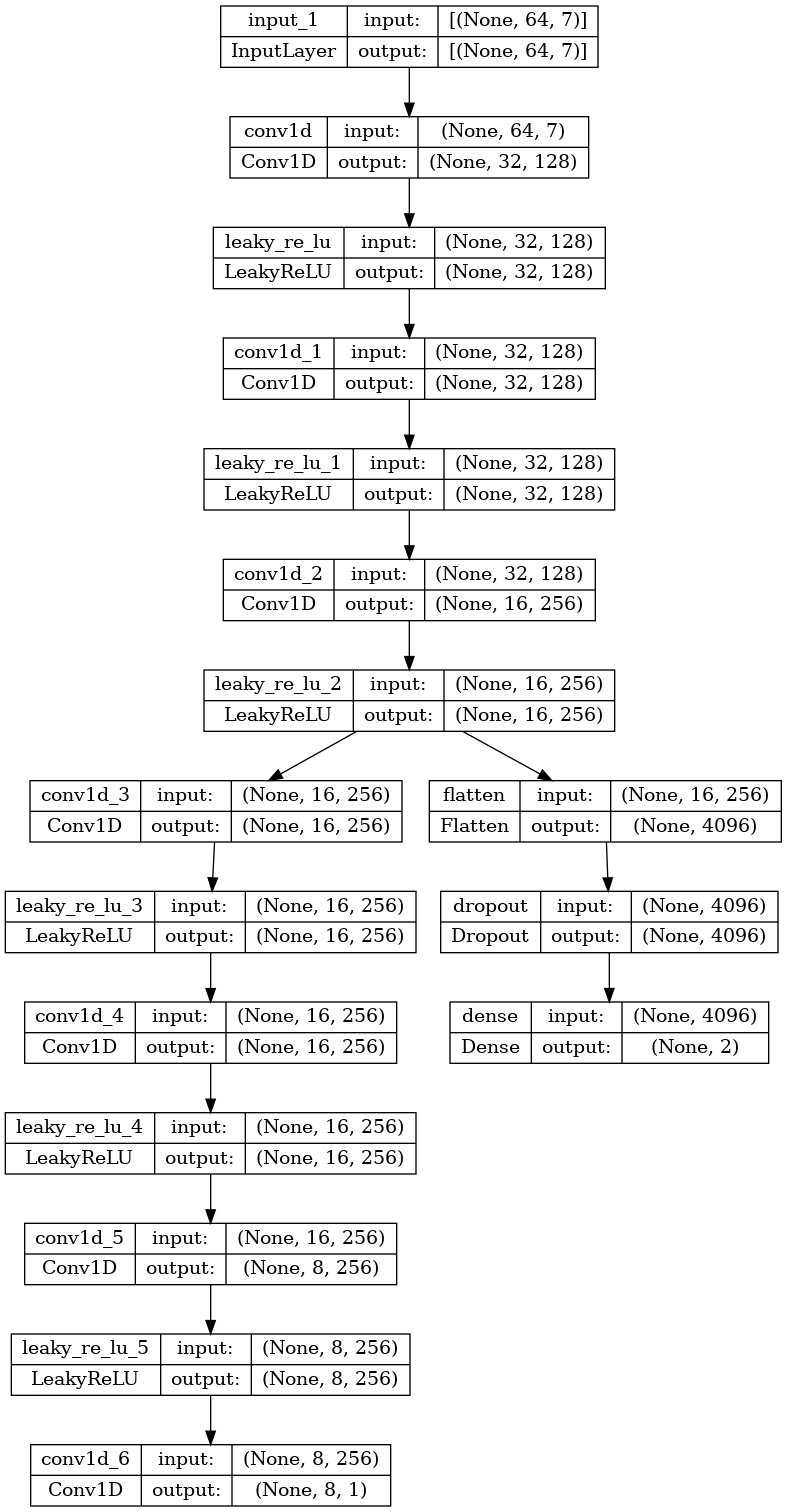

In [10]:
global_discriminator = make_multitask_discriminator(SEQUENCE_LENGTH, N_SIGNAL, n_style_class=2)
tf.keras.utils.plot_model(global_discriminator, show_shapes=True, to_file='discriminator.png')

In [11]:
content_encoder = make_content_encoder(SEQUENCE_LENGTH, N_SIGNAL, FEAT_WIENER)
# tf.keras.utils.plot_model(content_encoder, show_shapes=True, to_file='content_encoder.png')
# content_encoder.summary()

In [12]:
style_encoder = make_style_encoder(SEQUENCE_LENGTH, N_SIGNAL, STYLE_VECTOR_SIZE)
# tf.keras.utils.plot_model(style_encoder, show_shapes=True, to_file='style_encoder.png')
# style_encoder.summary()

In [13]:
decoder = make_decoder(N_SAMPLE_WIENER, FEAT_WIENER, STYLE_VECTOR_SIZE, N_SIGNAL)
# tf.keras.utils.plot_model(decoder, show_shapes=True, to_file='decoder.png')
# decoder.summary()

In [14]:
def generate(content_batch, style_batch):
    content = content_encoder(content_batch, training=False)
    style = style_encoder(style_batch, training=False)
    generated = decoder([content, style], training=False)
    return generated

In [15]:
def get_batches(dset, n_batches):
    _arr = np.array([c for c in dset.take(n_batches)])
    return _arr.reshape((-1, _arr.shape[-2], _arr.shape[-1]))

In [16]:
valid_seed_content = next(iter(content_dset_valid))
valid_seed_style = next(iter(style1_dset_valid))

train_seed_content = next(iter(content_dset_train))
train_seed_style = next(iter(style1_dset_train))

generated_sequence = generate(valid_seed_content[:int(VALID_BATCH_SIZE)], valid_seed_style)

2024-06-26 18:01:49.555776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2024-06-26 18:01:50.289471: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [17]:
def filter_prediction(x, threashold=.5):
    return tf.cast(x > threashold, tf.float32)* x

In [18]:
# Make seed sequence for particular style.

# train_dset_s1, valid_dset_s1 = pd_to_tf_dset(STYLE_DATASET_PATHS[0])
# train_dset_s2, valid_dset_s2 = pd_to_tf_dset(STYLE_DATASET_PATHS[1])

# content_dset_train, content_dset_valid
# style1_dset_train, style1_dset_valid
# style2_dset_train, style2_dset_valid

seed_content_train = get_batches(content_dset_train, 25)
seed_content_valid = get_batches(content_dset_valid, 25)

seed_style1_train = get_batches(style1_dset_train, 50)
seed_style1_valid = get_batches(style1_dset_valid, 50)

seed_style2_train = get_batches(style2_dset_train, 50)
seed_style2_valid = get_batches(style2_dset_valid, 50)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


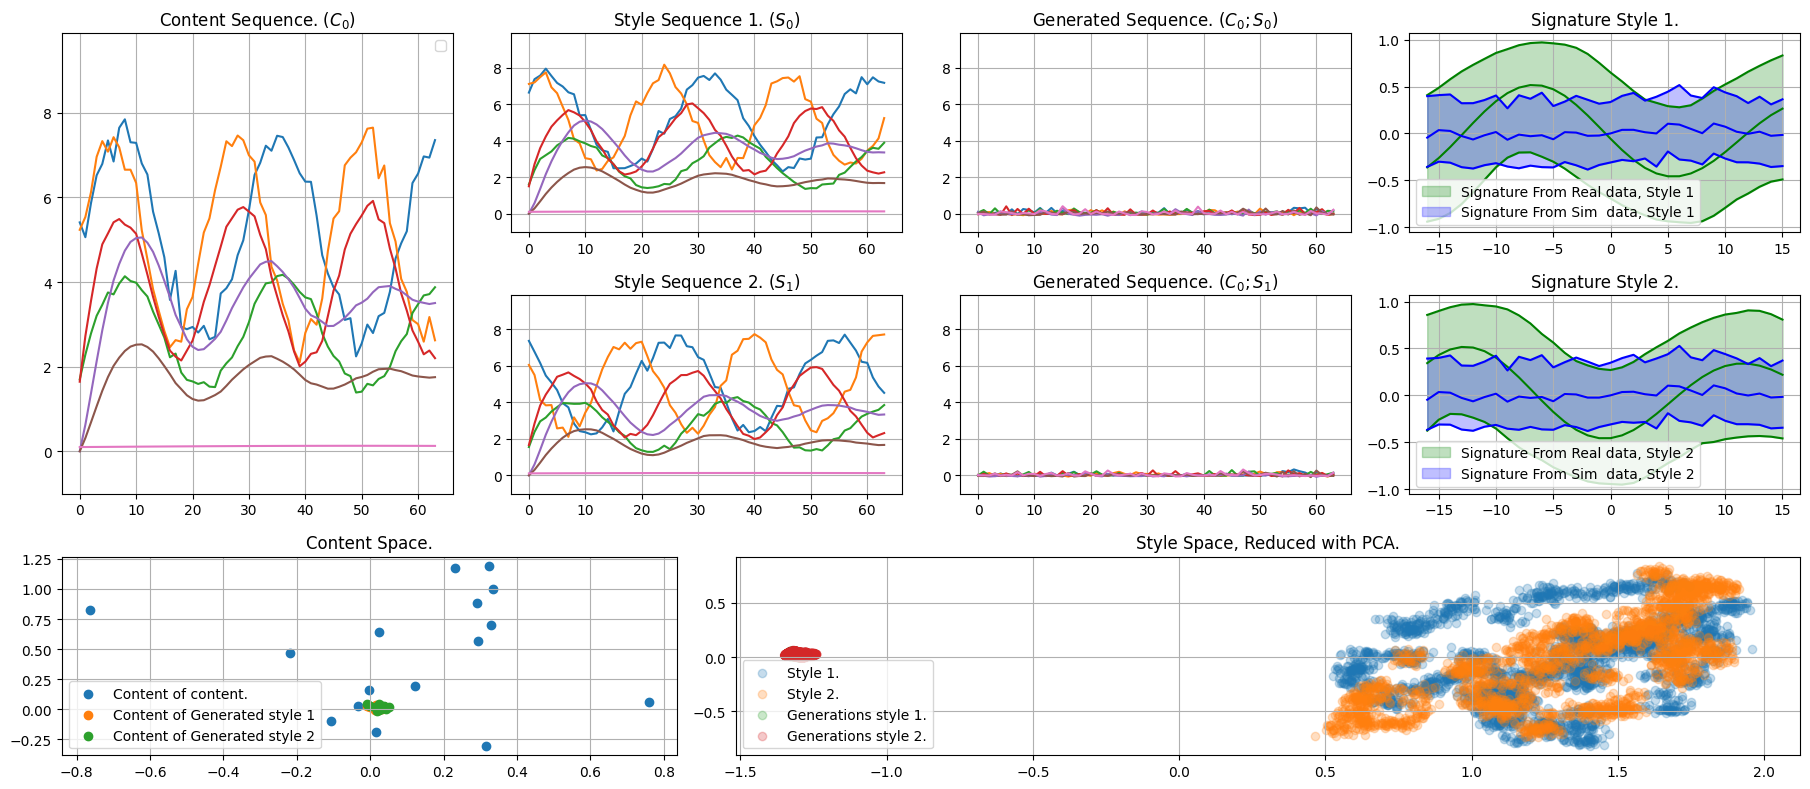

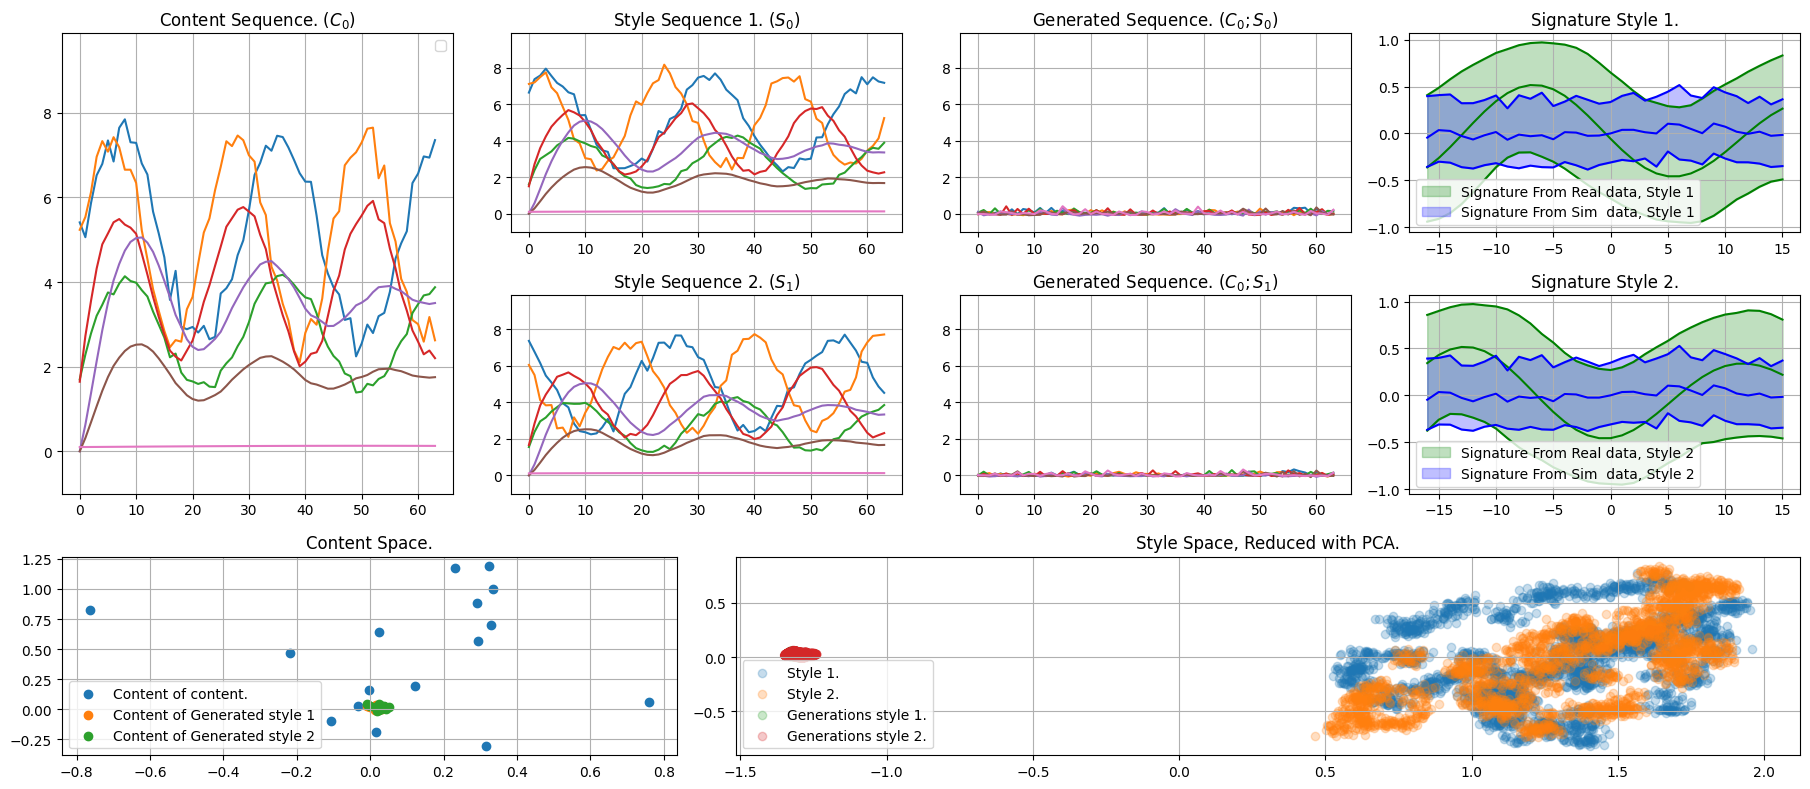

In [19]:
def plot_generated_sequence2(content_sequences, style1_sequences, style2_sequences, show=False):

    # Make Generated sequence for visualization.
    content_of_content = content_encoder(content_sequences, training=False)
    style_of_style1= style_encoder(style1_sequences, training=False)
    style1_generated = decoder([content_of_content, style_of_style1], training=False)

    style_of_style2 = style_encoder(style2_sequences, training=False)
    style2_generated = decoder([content_of_content, style_of_style2], training=False)

    c_style1_generated = content_encoder(style1_generated, training=False)
    s_style1_generated = style_encoder(style1_generated, training=False)

    c_style2_generated = content_encoder(style2_generated, training=False)
    s_style2_generated = style_encoder(style2_generated, training=False)

    style1_signature = signature_on_batch(style1_sequences, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
    style2_signature = signature_on_batch(style2_sequences, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
    gen_s1_signature = signature_on_batch(style1_generated, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
    gen_s2_signature = signature_on_batch(style2_generated, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)

    x = np.arange(style1_signature.shape[1]) - style1_signature.shape[1]/2

    averaged_rs1_sig = np.mean(style1_signature, axis=0)
    averaged_rs2_sig = np.mean(style2_signature, axis=0)
    averaged_gs1_sig = np.mean(gen_s1_signature, axis=0)
    averaged_gs2_sig = np.mean(gen_s2_signature, axis=0)

    sig_mins = np.min([averaged_rs1_sig, averaged_rs2_sig, averaged_gs1_sig, averaged_gs2_sig])- 5
    sig_max = np.max([averaged_rs1_sig, averaged_rs2_sig, averaged_gs1_sig, averaged_gs2_sig]) +5

    
    # Reduce the Style Vector for visualization purposes.
    pca = PCA(2)
    style_vectors = np.vstack(
        [   style_of_style1, 
            style_of_style2, 
            s_style1_generated, 
            s_style2_generated
        ])

    pca.fit(style_vectors)

    reduced_style1 = pca.transform(style_of_style1)
    reduced_style2 = pca.transform(style_of_style2)
    reduced_style1_generated = pca.transform(s_style1_generated)
    reduced_style2_generated = pca.transform(s_style2_generated)


    all_values = np.array([content_sequences, style1_sequences, style2_sequences])
    _min, _max = np.min(all_values)-1, np.max(all_values)+ 1

    fig= plt.figure(figsize=(18, 8))
    spec= fig.add_gridspec(3, 8)

    ax00 = fig.add_subplot(spec[0:2, :2])
    ax00.set_title('Content Sequence. ($C_0$)')
    ax00.plot(content_sequences[0])
    ax00.set_ylim(_min, _max)
    ax00.grid(True)
    ax00.legend()

# #######
    ax01 = fig.add_subplot(spec[0, 2:4])
    ax01.set_title('Style Sequence 1. ($S_0$)')
    ax01.plot(style1_sequences[0])
    ax01.set_ylim(_min, _max)
    ax01.grid(True)

    ax11 = fig.add_subplot(spec[1, 2:4])
    ax11.set_title("Style Sequence 2. ($S_1$)")
    ax11.plot(style2_sequences[0])
    ax11.set_ylim(_min, _max)
    ax11.grid(True)

# #######
    ax02 = fig.add_subplot(spec[0, 4:6])
    ax02.set_title('Generated Sequence. ($C_0; S_0$)')
    ax02.plot(style1_generated[0])
    ax02.set_ylim(_min, _max)
    ax02.grid(True) 

    ax12 = fig.add_subplot(spec[1, 4:6])
    ax12.set_title('Generated Sequence. ($C_0; S_1$)')
    ax12.plot(style2_generated[1])
    ax12.set_ylim(_min, _max)
    ax12.grid(True) 

# #####

    ax03 = fig.add_subplot(spec[0, 6:])
    ax03.set_title("Signature Style 1.")


    plt.plot(x, averaged_rs1_sig[:, 0], "g")
    plt.plot(x, averaged_rs1_sig[:, 1], "g")
    plt.plot(x, averaged_rs1_sig[:, 2], "g")

    plt.plot(x, averaged_gs1_sig[:, 0], "b")
    plt.plot(x, averaged_gs1_sig[:, 1], "b")
    plt.plot(x, averaged_gs1_sig[:, 2], "b")


    plt.fill_between(x, averaged_rs1_sig[:, 0].reshape((-1,)), averaged_rs1_sig[:, 1].reshape((-1,)), color="g", alpha=0.25, label="Signature From Real data, Style 1")
    plt.fill_between(x, averaged_gs1_sig[:, 0].reshape((-1,)), averaged_gs1_sig[:, 1].reshape((-1,)), color="b", alpha=0.25, label="Signature From Sim  data, Style 1")

    ax03.grid(True)
    ax03.legend()
    

    ax04 = fig.add_subplot(spec[1, 6:])
    ax04.set_title("Signature Style 2.")

    plt.plot(x, averaged_rs2_sig[:, 0], "g")
    plt.plot(x, averaged_rs2_sig[:, 1], "g")
    plt.plot(x, averaged_rs2_sig[:, 2], "g")

    plt.plot(x, averaged_gs2_sig[:, 0], "b")
    plt.plot(x, averaged_gs2_sig[:, 1], "b")
    plt.plot(x, averaged_gs2_sig[:, 2], "b")

    plt.fill_between(x, averaged_rs2_sig[:, 0].reshape((-1,)), averaged_rs2_sig[:, 1].reshape((-1,)), color="g", alpha=0.25, label="Signature From Real data, Style 2")
    plt.fill_between(x, averaged_gs2_sig[:, 0].reshape((-1,)), averaged_gs2_sig[:, 1].reshape((-1,)), color="b", alpha=0.25, label="Signature From Sim  data, Style 2")

    ax04.grid(True)
    ax04.legend()


# #####
    ax10 = fig.add_subplot(spec[2, :3])
    ax10.set_title('Content Space.')
    ax10.scatter(content_of_content[0, :, 0], content_of_content[0, :, 1],  label='Content of content.')
    ax10.scatter(c_style1_generated[0, :, 0], c_style1_generated[0, :, 1], label='Content of Generated style 1')
    ax10.scatter(c_style2_generated[0, :, 0], c_style2_generated[0, :, 1],  label='Content of Generated style 2')
    ax10.grid(True)
    ax10.legend()

    ax11 = fig.add_subplot(spec[2, 3:])
    ax11.set_title('Style Space, Reduced with PCA.')
    ax11.scatter(reduced_style1[:, 0], reduced_style1[:, 1], label='Style 1.', alpha=0.25)
    ax11.scatter(reduced_style2[:, 0], reduced_style2[:, 1], label='Style 2.', alpha=0.25)
    ax11.scatter(reduced_style1_generated[:, 0], reduced_style1_generated[:, 1], label='Generations style 1.', alpha=0.25)
    ax11.scatter(reduced_style2_generated[:, 0], reduced_style2_generated[:, 1], label='Generations style 2.', alpha=0.25)

    ax11.grid(True)
    ax11.legend()

    plt.tight_layout()

    return fig

plot_generated_sequence2(seed_content_valid, seed_style1_valid, seed_style2_valid)

In [ ]:
def fig_to_buff(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    plt.close(fig)
    return buf

## Define losses.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
error_classif = tf.keras.losses.SparseCategoricalCrossentropy()

def recontruction_loss(true:tf.Tensor, generated:tf.Tensor):
    diff = generated- true
    result = tf.math.reduce_mean(tf.square(diff))
    return result

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def fixed_point_content(encoded_content_real, encoded_content_fake):
    diff = encoded_content_fake- encoded_content_real
    return tf.reduce_mean(tf.square(diff))

def style_classsification_loss(y_pred, y_true):
    return error_classif(y_true, y_pred)

## Tensorboard Logs.

In [ ]:
# Train Metrics
# Generator Losses
met_generator_train = tf.keras.metrics.Mean(name="Total Generator Loss")
met_generator_reconstr_from_content_train= tf.keras.metrics.Mean(name="Reconstruction from Content")
met_generator_realness_train= tf.keras.metrics.Mean(name="Realness of Generations")

# Style Encoder Loss
met_triplet_train = tf.keras.metrics.Mean(name="Total Triplet Loss")
met_disentanglement_train = tf.keras.metrics.Mean(name="Disentanglement Loss")
met_style_encoder_train = tf.keras.metrics.Mean(name="Style Loss")

# Content encoder Loss
met_content_encoder_train= tf.keras.metrics.Mean(name="Content Encoder Loss")

# Correlation Metric
met_correlation_metric_train = tf.keras.metrics.Mean(name="Correlation Metric")

# Discriminator Loss
met_disc_loss_train= tf.keras.metrics.Mean(name="Discriminator Loss")
met_style_classif_on_real_train = tf.keras.metrics.Mean(name="Style Classification Loss on Real Sequences")
met_style_classif_on_gen_train = tf.keras.metrics.Mean(name="Style Classification Loss on Generated Sequences")

# Style of Reconstruction (ajouté ici mais plus un bout de scotch qu'autre chose...).
met_style_reconstruction = tf.keras.metrics.Mean(name="Style Reconstruction")

# Correlation Metric
met_corr_style1_train = tf.keras.metrics.Mean(name="Correlation Metric Style 1")
met_corr_style2_train = tf.keras.metrics.Mean(name="Correlation Metric Style 2")


# Valid Metrics
# Generator Metric
met_generator_valid = tf.keras.metrics.Mean(name="Total Generator Loss")
met_generator_reconstr_from_content_valid= tf.keras.metrics.Mean(name="Reconstruction from Content")
met_generator_realness_valid= tf.keras.metrics.Mean(name="Realness of Generations")

# Style encoder Loss
met_triplet_valid = tf.keras.metrics.Mean(name="Triplet Loss")
met_disentanglement_valid = tf.keras.metrics.Mean(name="Disentanglement Loss")
met_style_encoder_valid = tf.keras.metrics.Mean(name="Style Loss")

# Content Encoder Loss
met_content_encoder_valid= tf.keras.metrics.Mean(name="Content Encoder Loss")

# Discriminator Loss
met_disc_loss_valid= tf.keras.metrics.Mean(name="Discriminator Loss")
met_style_classif_on_real_valid = tf.keras.metrics.Mean(name="Style Classification Loss on Real Sequences")
met_style_classif_on_gen_valid = tf.keras.metrics.Mean(name="Style Classification Loss on Generated Sequences")

# correlation Metric
met_corr_style1_valid = tf.keras.metrics.Mean(name="Correlation Metric Style 1")
met_corr_style2_valid = tf.keras.metrics.Mean(name="Correlation Metric Style 2")

# Style of Reconstruction (ajouté ici mais plus un bout de scotch qu'autre chose...).
met_style_reconstruction_valid = tf.keras.metrics.Mean(name="Style Reconstruction")

In [ ]:
TRAIN_SUMMARY_WRITER = tf.summary.create_file_writer(TRAIN_LOGS_DIR_PATH)
VALID_SUMMARY_WRITER = tf.summary.create_file_writer(VALID_LOGS_DIR_PATH)

def log_train_losses(epoch, plot_buf):
    image = tf.image.decode_png(plot_buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    with TRAIN_SUMMARY_WRITER.as_default():
        tf.summary.scalar("00 - Correlation Metric Style 1", met_corr_style1_train.result(), step=epoch)
        tf.summary.scalar("01 - Correlation Metric Style 2", met_corr_style2_train.result(), step=epoch)


        tf.summary.scalar("10 - Total Generator Loss", met_generator_train.result(), step=epoch)
        tf.summary.scalar("11 - Reconstruction from Content", met_generator_reconstr_from_content_train.result(), step=epoch)
        tf.summary.scalar("12 - Realness Loss", met_generator_realness_train.result(), step=epoch)
        tf.summary.scalar("13 - Style Classification on Generations", met_style_classif_on_gen_train.result(), step=epoch)

        tf.summary.scalar("20 - Style Loss", met_style_encoder_train.result(), step=epoch)
        tf.summary.scalar("21 - Triplet Loss", met_triplet_train.result(), step=epoch)
        tf.summary.scalar("22 - Disentanglement Loss", met_disentanglement_train.result(), step=epoch)

        tf.summary.scalar("30 - Content Loss", met_content_encoder_train.result(), step=epoch)

        tf.summary.scalar("40 - Discriminator Loss", met_disc_loss_train.result(), step=epoch)
        tf.summary.scalar("41 - Style Classification on Real", met_style_classif_on_real_train.result(), step=epoch)

        tf.summary.image("Training Generations", image, step=epoch)


def log_valid_losses(epoch):
    with VALID_SUMMARY_WRITER.as_default():
        tf.summary.scalar("00 - Correlation Metric Style 1", met_corr_style1_valid.result(), step=epoch)
        tf.summary.scalar("01 - Correlation Metric Style 2", met_corr_style2_valid.result(), step=epoch)

        tf.summary.scalar("10 - Total Generator Loss", met_generator_valid.result(), step=epoch)
        tf.summary.scalar("11 - Reconstruction from Content", met_generator_reconstr_from_content_valid.result(), step=epoch)
        tf.summary.scalar("12 - Realness Loss", met_generator_realness_valid.result(), step=epoch)
        tf.summary.scalar("13 - Style Classification on Generations", met_style_classif_on_gen_valid.result(), step=epoch)

        tf.summary.scalar("20 - Style Loss", met_style_encoder_valid.result(), step=epoch)
        tf.summary.scalar("21 - Triplet Loss", met_triplet_valid.result(), step=epoch)
        tf.summary.scalar("22 - Disentanglement Loss", met_disentanglement_valid.result(), step=epoch)

        tf.summary.scalar("30 - Content Loss", met_content_encoder_valid.result(), step=epoch)

        tf.summary.scalar("40 - Discriminator Loss", met_disc_loss_valid.result(), step=epoch)
        tf.summary.scalar("41 - Style Classification on Real", met_style_classif_on_real_valid.result(), step=epoch)
        


def reset_metric_states():
    met_generator_train.reset_states()
    met_generator_reconstr_from_content_train.reset_states()
    met_generator_realness_train.reset_states()
    met_triplet_train.reset_states()
    met_disentanglement_train.reset_states()
    met_style_encoder_train.reset_states()
    met_content_encoder_train.reset_states()
    met_corr_style1_train.reset_states()
    met_corr_style2_train.reset_states()
    met_disc_loss_train.reset_states()
    met_style_reconstruction.reset_states()
    met_correlation_metric_train.reset_states()
    met_style_classif_on_real_train.reset_states()
    met_style_classif_on_gen_train.reset_states()


def reset_valid_states():
    met_generator_valid.reset_states()
    met_generator_reconstr_from_content_valid.reset_states()
    met_generator_realness_valid.reset_states()
    met_triplet_valid.reset_states()
    met_disentanglement_valid.reset_states()
    met_style_encoder_valid.reset_states()
    met_content_encoder_valid.reset_states()
    met_corr_style1_valid.reset_states()
    met_corr_style2_valid.reset_states()
    met_disc_loss_valid.reset_states()
    met_style_reconstruction.reset_states()
    met_style_classif_on_real_valid.reset_states()
    met_style_classif_on_gen_valid.reset_states()


## Instantiate model for training.

In [ ]:
content_encoder = make_content_encoder(SEQUENCE_LENGTH, N_SIGNAL, FEAT_WIENER)
style_encoder = make_style_encoder(SEQUENCE_LENGTH, N_SIGNAL, STYLE_VECTOR_SIZE)
decoder = make_decoder(N_SAMPLE_WIENER, FEAT_WIENER, STYLE_VECTOR_SIZE ,N_SIGNAL)


opt_content_encoder = tf.keras.optimizers.Adam(learning_rate=0.0002)
opt_style_encoder = tf.keras.optimizers.Adam(learning_rate=0.0002)
opt_decoder = tf.keras.optimizers.Adam(learning_rate=0.0002)
opt_discr = tf.keras.optimizers.Adam(learning_rate=0.0002)

# opt_content_encoder = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
# opt_style_encoder = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
# opt_decoder = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
# opt_discr = tf.keras.optimizers.RMSprop(learning_rate=1e-5)

## Train the model

In [ ]:
from itertools import product
indexes = np.array(list(product(range(BS), range(BS))))
other_index = np.arange(BS)* BS

In [ ]:
anchor_indexes = np.array([ i* BS+i for i in range(BS) for _ in range(BS) ])
pos_indexes = np.array([ BS*j + i for i in range(BS) for j in range(BS)])
neg_indexes = np.array([ (j*BS + (i+1)%BS) for i in range(BS) for j in range(BS)])

In [ ]:
def get_style_voctor_for_dis_loss(style_vector:tf.Tensor, batch_size:int):
    anchor_indexes = np.array([ i* batch_size+i for i in range(batch_size) for _ in range(batch_size-1) ])
    return tf.gather(style_vector, anchor_indexes)

def get_anchor_positive_negative_from_batch(style_from_style_ts:tf.Tensor, style_of_generations:tf.Tensor, batch_size:int):
    anchor_indexes = np.array([ i* batch_size+i for i in range(batch_size) for _ in range(batch_size) ])
    pos_indexes = np.array([ batch_size*j + i for i in range(batch_size) for j in range(batch_size)])
    neg_indexes = np.array([ (j*batch_size + (i+1)%batch_size) for i in range(batch_size) for j in range(batch_size)])

    # Anchor are for example:
    # [(c0, s0), (c0, s0), 
    # (c1, s1), (c1, s1), ...]
    anchors = tf.gather(style_from_style_ts, anchor_indexes)
    # Different content, Same Style:
    # [(c1, s0), (c2, s0),(c2, s0),
    #  (c1, s1), (c2, s1), (c3, s1)...]
    # E_s(G(x, y1))
    pos_vector= tf.gather(style_of_generations, pos_indexes)
    # Same content but different style
    # [(c1, s1), (c2, s1),(c2, s1),
    #  (c1, s2), (c2, s2), (c3, s2)...]
    # # E_s(G(x, y2)) 
    neg_vector = tf.gather(style_of_generations, neg_indexes)

    return anchors, pos_vector, neg_vector

def get_dissantanglement_loss_component(style_of_generations, style_of_style, batch_size:int):
    anchor_indexes = np.array([ i* batch_size+i for i in range(batch_size) for _ in range(batch_size-1) ])
    pos_indexes = np.array([ batch_size*j + i for i in range(batch_size) for j in range(batch_size) if i !=j ])

    es_y = tf.gather(style_of_style, anchor_indexes)
    es_x1_y = tf.gather(style_of_generations, anchor_indexes)
    es_x2_y = tf.gather(style_of_generations, pos_indexes)

    return es_y, es_x1_y, es_x2_y


def l2(x:tf.Tensor, y:tf.Tensor):
    diff = tf.square(y- x)
    _distance = tf.reduce_sum(diff, axis=-1)
    return _distance


def fixed_point_content(encoded_content_real, encoded_content_fake):
    diff = l2(encoded_content_real, encoded_content_fake)
    return tf.reduce_mean(diff)

def fixed_point_triplet_style_loss(anchor_encoded_style, positive_encoded_style, negative_encoded_style):
    # shape: [BS, Style_length]
    negative_distance = l2(negative_encoded_style, anchor_encoded_style)
    positive_distance = l2(positive_encoded_style, anchor_encoded_style)

    triplet = TRIPLET_R+ positive_distance- negative_distance
    zeros = tf.zeros_like(triplet)
    triplet = tf.math.maximum(triplet, zeros)

    loss = tf.reduce_mean(triplet)
    return loss

def fixed_point_disentanglement(
        es_x1_y:tf.Tensor, 
        es_x2_y:tf.Tensor, 
        es_y:tf.Tensor
        ):

    diff1 = l2(es_x1_y, es_x2_y)
    diff2 = l2(es_x1_y, es_y)

    loss = diff1- diff2
    zeros = tf.zeros_like(loss)
    loss = tf.math.maximum(loss, zeros)
    loss = tf.reduce_mean(loss)
    return loss


def style_constrain_loss(style_of_style_batch, style_of_generation):
    diff = l2(style_of_style_batch, style_of_generation)
    diff = tf.reduce_mean(diff)
    return diff

In [ ]:
def _pairwise_distance(a_embeddings, b_embeddings):
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(a_embeddings, tf.transpose(b_embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.linalg.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    return distances

def get_positives(labels):
    # will assign 1 where this is a positive 
    positive_mask = np.array([ tf.cast(labels == l, tf.float32) for l in labels])
    positive_mask = positive_mask - np.identity(positive_mask.shape[0])
    return positive_mask

def get_negative(labels):
    neg_labels= np.array([ tf.cast(labels != l, tf.float32) for l in labels])
    return neg_labels


def get_triplet_loss(anchor_embedding, positive_embedding, negative_embedding):
    positive_distance= _pairwise_distance(anchor_embedding, positive_embedding)
    negative_distance= _pairwise_distance(anchor_embedding, negative_embedding)

    positive_index= tf.argmax(positive_distance, axis=1)

    pos_embedding = tf.gather(positive_embedding, positive_index)
 
    neg_indexes = tf.argmin(negative_distance, axis=1)
    
    neg_embeddings= tf.gather(negative_embedding, neg_indexes)

    positive_distances= l2(anchor_embedding, pos_embedding)
    negative_distances= l2(anchor_embedding, neg_embeddings)

    loss = tf.reduce_mean(tf.maximum(TRIPLET_R+ positive_distances - negative_distances, 0))

    return loss

def compute_metric(generated_style:tf.Tensor, true_style:tf.Tensor):
    true_signature = signature_on_batch(true_style, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)
    generated_signature= signature_on_batch(generated_style, config.met_params.ins, config.met_params.outs, config.met_params.signature_length)

    return signature_metric(true_signature, generated_signature)

In [ ]:
def filter_prediction(x, threashold=.5):
    return tf.cast(x > threashold, tf.float32)* x

In [ ]:
@tf.function
def valid_step(content_sequence1, content_sequence2, style1_sequences, style2_sequences):
    # Discriminator Step
    # Sequence generations.
    c1 = content_encoder(content_sequence1, training=False)

    s1 = style_encoder(style1_sequences, training=False)
    s2 = style_encoder(style2_sequences, training=False)

    style1_generated= decoder([c1, s1], training=False)
    style2_generated= decoder([c1, s2], training=False)

    # We classify style sequences because 
    # they are only real sequences with style labels :) 
    crit_real1, style_classif_real1 = global_discriminator(style1_sequences, training=False)
    crit_real2, style_classif_real2 = global_discriminator(style2_sequences, training=False)

    crit_fake1, _ = global_discriminator(style1_generated, training=False)
    crit_fake2, _ = global_discriminator(style2_generated, training=False)

    # Make a threasold on the predictions.
    # crit_fake1 = filter_prediction(crit_fake1, threashold=DISCR_THREASOLD)
    # crit_fake2 = filter_prediction(crit_fake2, threashold=DISCR_THREASOLD)

    # Compute the loss for the Discriminator
    crit_loss1 = discriminator_loss(crit_real1, crit_fake1)
    crit_loss2 = discriminator_loss(crit_real2, crit_fake2)
    crit_loss = (crit_loss1 + crit_loss2)/2
    
    l_style1_real = style_classsification_loss(style_classif_real1, tf.zeros((style_classif_real1.shape[0], 1))+0.)
    l_style2_real = style_classsification_loss(style_classif_real2, tf.zeros((style_classif_real2.shape[0], 1))+1.)
    l_style_real = (l_style1_real+ l_style2_real)/2

    # Here, things get a little bit more complicated :)
    contents = tf.concat([content_sequence1, content_sequence2], 0)
    cs = content_encoder(contents, training=False)
    s_cs = style_encoder(contents, training=False)
    id_generated = decoder([cs, s_cs], training=False)
    reconstr_loss = recontruction_loss(contents, id_generated)

    ####
    contents = tf.concat([content_sequence1, content_sequence2, content_sequence1, content_sequence2], 0)
    styles = tf.concat([style1_sequences, style1_sequences, style2_sequences, style2_sequences], 0)
    _bs = content_sequence1.shape[0]

    encoded_content= content_encoder(contents, training=False)
    encoded_styles = style_encoder(styles, training=False)

    generations = decoder([encoded_content, encoded_styles], training=False)

    s_generations = style_encoder(generations, training=False)
    c_generations = content_encoder(generations, training=False)
    
    labels = np.zeros((4* _bs,))
    labels[2* _bs:] = 1.

    # Discriminator pass for the adversarial loss for the generator.
    crit_on_fake, style_classif_fakes = global_discriminator(generations, training=False)
    # crit_on_fake = filter_prediction(crit_on_fake, threashold=DISCR_THREASOLD)

    
    # The Style label should be preserved through generations...
    style_label_preservation = style_classsification_loss(style_classif_fakes, labels)

    c1s = tf.concat([
        encoded_content[:_bs],                  # 2
        encoded_content[2*_bs:3* _bs]           # 3
    ], 0)

    c2s = tf.concat([
        encoded_content[_bs:2* _bs],            # 2
        encoded_content[3*_bs:]                 # 4 
    ], 0)

    generated_c1s = tf.concat([
        c_generations[:_bs],
        c_generations[2*_bs:3* _bs]
    ], 0)

    generated_c2s = tf.concat([
        c_generations[_bs:2* _bs],
        c_generations[3*_bs:]
    ], 0)

    s_c1_s1 = s_generations[:_bs]
    s_c1_s2 = s_generations[2*_bs: 3*_bs]
    s_c2_s2 = s_generations[3*_bs:] 

    realness = generator_loss(crit_on_fake)

    content_preservation1 = fixed_point_content(c1s, generated_c1s)
    content_preservation2 = fixed_point_content(c2s, generated_c2s)
    content_preservation = (content_preservation1+ content_preservation2)/2

    triplet_style =  get_triplet_loss(s1, s_c1_s1, s_c1_s2)
    content_style_disentenglement = fixed_point_disentanglement(s2, s_c1_s2, s_c2_s2)

    style_encoder_loss = L_TRIPLET* triplet_style + L_DIS* content_style_disentenglement
    g_loss = L_RECONSTR* reconstr_loss+ L_ADV* realness + L_ADV* style_label_preservation

    met_generator_valid(g_loss)
    met_style_classif_on_gen_valid(style_label_preservation)
    met_generator_reconstr_from_content_valid(reconstr_loss)
    met_generator_realness_valid(realness)

    met_style_encoder_valid(style_encoder_loss)
    met_triplet_valid(triplet_style)
    met_disentanglement_valid(content_style_disentenglement)

    met_content_encoder_valid(content_preservation)
    met_disc_loss_valid(crit_loss)
    met_style_classif_on_real_valid(l_style_real)

In [ ]:
@tf.function
def train_step(content_sequence1, content_sequence2, style1_sequences, style2_sequences, update_discr):
    # Discriminator Step
    with tf.GradientTape() as discr_tape:
        # Sequence generations.
        c1 = content_encoder(content_sequence1, training=False)

        s1 = style_encoder(style1_sequences, training=False)
        s2 = style_encoder(style2_sequences, training=False)

        style1_generated= decoder([c1, s1], training=False)
        style2_generated= decoder([c1, s2], training=False)

        # We classify style sequences because 
        # they are only real sequences with style labels :) 
        crit_real1, style_classif_real1 = global_discriminator(style1_sequences, training=update_discr)
        crit_real2, style_classif_real2 = global_discriminator(style2_sequences, training=update_discr)

         # Make a threasold on the predictions.
        # style_classif_real1 = filter_prediction(style_classif_real1, threashold=DISCR_THREASOLD)
        # style_classif_real2 = filter_prediction(style_classif_real2, threashold=DISCR_THREASOLD)


        crit_fake1, _ = global_discriminator(style1_generated, training=update_discr)
        crit_fake2, _ = global_discriminator(style2_generated, training=update_discr)


        # Compute the loss for the Discriminator
        crit_loss1 = discriminator_loss(crit_real1, crit_fake1)
        crit_loss2 = discriminator_loss(crit_real2, crit_fake2)
        crit_loss = (crit_loss1 + crit_loss2)/2
        
        l_style1_real = style_classsification_loss(style_classif_real1, tf.zeros((style_classif_real1.shape[0], 1))+0.)
        l_style2_real = style_classsification_loss(style_classif_real2, tf.zeros((style_classif_real2.shape[0], 1))+1.)
        l_style_real = (l_style1_real+ l_style2_real)/2

    # Here, things get a little bit more complicated :)
    with tf.GradientTape() as content_tape, tf.GradientTape() as style_tape, tf.GradientTape() as decoder_tape:
        contents = tf.concat([content_sequence1, content_sequence2], 0)
        cs = content_encoder(contents, training=True)
        s_cs = style_encoder(contents, training=True)
        id_generated = decoder([cs, s_cs], training=True)
        reconstr_loss = recontruction_loss(contents, id_generated)

        ####
        contents = tf.concat([content_sequence1, content_sequence2, content_sequence1, content_sequence2], 0)
        styles = tf.concat([style1_sequences, style1_sequences, style2_sequences, style2_sequences], 0)
        _bs = content_sequence1.shape[0]

        encoded_content= content_encoder(contents, training=True)
        encoded_styles = style_encoder(styles, training=True)

        generations = decoder([encoded_content, encoded_styles], training=True)

        s_generations = style_encoder(generations, training=True)
        c_generations = content_encoder(generations, training=True)
        
        style_labels = np.zeros((4* _bs,))
        style_labels[2* _bs:]= 1.

        # Discriminator pass for the adversarial loss for the generator.
        crit_on_fake, style_classif_fakes = global_discriminator(generations, training=False)

        

        
        # The Style label should be preserved through generations...
        style_label_preservation = style_classsification_loss(style_classif_fakes, style_labels)

        c1s = tf.concat([
            encoded_content[:_bs],                  # 2
            encoded_content[2*_bs:3* _bs]           # 3
        ], 0)

        c2s = tf.concat([
            encoded_content[_bs:2* _bs],            # 2
            encoded_content[3*_bs:]                 # 4 
        ], 0)

        generated_c1s = tf.concat([
            c_generations[:_bs],
            c_generations[2*_bs:3* _bs]
        ], 0)

        generated_c2s = tf.concat([
            c_generations[_bs:2* _bs],
            c_generations[3*_bs:]
        ], 0)

        s_c1_s1 = s_generations[:_bs]
        s_c1_s2 = s_generations[2*_bs: 3*_bs]
        s_c2_s2 = s_generations[3*_bs:] 

        s1s = encoded_styles[:_bs]
        s2s = encoded_styles[2* _bs:3* _bs]

        realness = generator_loss(crit_on_fake)

        content_preservation1 = fixed_point_content(c1s, generated_c1s)
        content_preservation2 = fixed_point_content(c2s, generated_c2s)
        content_preservation = (content_preservation1+ content_preservation2)/2

        triplet_style =  get_triplet_loss(s1s, s_c1_s1, s_c1_s2)

        content_style_disentenglement = fixed_point_disentanglement(s_c2_s2, s_c1_s2, s2s)

        content_encoder_loss = L_CONTENT* content_preservation
        style_encoder_loss = L_TRIPLET* triplet_style + L_DIS* content_style_disentenglement
        g_loss = L_RECONSTR* reconstr_loss+ L_ADV* realness + L_ADV* style_label_preservation

    # Make the Networks Learn!
    if update_discr == True:
        discr_grads = discr_tape.gradient([crit_loss, l_style_real], global_discriminator.trainable_variables)
    content_grad=content_tape.gradient(content_encoder_loss, content_encoder.trainable_variables)
    style_grad = style_tape.gradient(style_encoder_loss, style_encoder.trainable_variables)
    decoder_grad = decoder_tape.gradient(g_loss, decoder.trainable_variables)
        
    if update_discr == True:
        opt_discr.apply_gradients(zip(discr_grads, global_discriminator.trainable_variables))
    opt_content_encoder.apply_gradients(zip(content_grad, content_encoder.trainable_variables))
    opt_style_encoder.apply_gradients(zip(style_grad, style_encoder.trainable_variables))
    opt_decoder.apply_gradients(zip(decoder_grad, decoder.trainable_variables))

    met_generator_train(g_loss)
    met_style_classif_on_gen_train(style_label_preservation)
    met_generator_reconstr_from_content_train(reconstr_loss)
    met_generator_realness_train(realness)

    met_style_encoder_train(style_encoder_loss)
    met_triplet_train(triplet_style)
    met_disentanglement_train(content_style_disentenglement)

    met_content_encoder_train(content_preservation)
    met_disc_loss_train(crit_loss)
    met_style_classif_on_real_train(l_style_real)

In [ ]:
def train():
    total_batch = "?"
    for e in range(EPOCHS):
        reset_metric_states()
        reset_valid_states()
        
        print("[+] Train Step...")
        for i, (content_batch, style1_sequences, style2_sequences) in enumerate(zip(content_dset_train, style1_dset_train, style2_dset_train)):
            update_discr = i%DISCR_STEP == 0
            content_sequence1 = content_batch[:int(BS)]
            content_sequence2 = content_batch[int(BS):]

            train_step(content_sequence1, content_sequence2, style1_sequences, style2_sequences, update_discr)
            print(f"\r e:{e}/{EPOCHS}; {i}/{total_batch}. G_loss {met_generator_train.result():0.2f} Triplet Loss {met_triplet_train.result():0.2f}; Disentanglement Loss: {met_disc_loss_train.result():0.2f}; Content Loss {met_content_encoder_train.result():0.2f} D Loss {met_disc_loss_train.result():0.2f}; Classif [Real; Fake]: [{met_style_classif_on_real_train.result():0.2f}; {met_style_classif_on_gen_train.result():0.2f}] {update_discr}        ", end="")

        print()
        print("[+] Validation Step...")
        for vb, (content_batch, style1_sequences, style2_sequences) in enumerate(zip(content_dset_valid, style1_dset_valid, style2_dset_valid)):
            content_sequence1 = content_batch[:int(VALID_BATCH_SIZE)]
            content_sequence2 = content_batch[int(VALID_BATCH_SIZE):]

            valid_step(content_sequence1, content_sequence2, style1_sequences, style2_sequences)
            print(f"\r e:{e}/{EPOCHS}; {vb}. G_loss {met_generator_valid.result():0.2f} Triplet Loss {met_triplet_valid.result():0.2f}; Disentanglement Loss: {met_disc_loss_train.result():0.2f}; Content Loss {met_content_encoder_train.result():0.2f} D Loss {met_disc_loss_train.result():0.2f}Classif [Real; Fake]: [{met_style_classif_on_real_valid.result():0.2f}; {met_style_classif_on_gen_valid.result():0.2f}]         ", end="")
    
        # Make Generations Train Set
        generation_style1_train = generate(seed_content_train, seed_style1_train)
        generation_style1_valid = generate(seed_content_valid, seed_style1_valid)

        generation_style2_train = generate(seed_content_train, seed_style2_train)
        generation_style2_valid = generate(seed_content_valid, seed_style2_valid)
        
        metric_s1_train = compute_metric(generation_style1_train, seed_style1_train)
        metric_s1_valid = compute_metric(generation_style1_valid, seed_style1_valid)

        metric_s2_train = compute_metric(generation_style2_train, seed_style2_train)
        metric_s2_valid = compute_metric(generation_style2_valid, seed_style2_valid)


        met_corr_style1_train(metric_s1_train)
        met_corr_style2_train(metric_s2_train)

        met_corr_style1_valid(metric_s1_valid)
        met_corr_style2_valid(metric_s2_valid)

        vis_fig = plot_generated_sequence2(seed_content_valid, seed_style1_valid, seed_style2_valid)
        plot_buff = fig_to_buff(vis_fig)
        
        print("\n******* Signature Difference *******")
        print(f"Style 1:")
        print(f"Train: {metric_s1_train}; Valid: {metric_s1_valid}")

        print(f"Style 2:")
        print(f"Train: {metric_s2_train}; Valid: {metric_s2_valid}")

        print("*******")

        log_train_losses(e, plot_buff)
        log_valid_losses(e)
        print()

        if e == 0:
            total_batch = i 

train()

## Test Pipeline

### TSTR Method

In [ ]:
from models.NaiveClassifier import make_naive_discriminator

def make_classification_dataset(df:pd.DataFrame, overlap:float=.5):

    dset_train, dset_valid = make_train_valid_dset(
        df, 
        SEQUENCE_LENGTH, 
        GRANUARITY, 
        int(overlap* SEQUENCE_LENGTH),
        64,
        64,
        shuffle=True
    )

    # Extract labels from dataset.
    dset_train = dset_train.map(lambda s: (s[:, :, :-1], s[:, int(SEQUENCE_LENGTH//2), -1]))
    dset_valid = dset_valid.map(lambda s: (s[:, :, :-1], s[:, int(SEQUENCE_LENGTH//2), -1]))

    return dset_train, dset_valid

def stylize_dataset(content_dataset:tf.data.Dataset, style_dataset:tf.data.Dataset):
    mixted_dataset = tf.data.Dataset.zip((content_dataset, style_dataset))
    stylized_dataset = mixted_dataset.map(lambda _cont, _sty: (generate(_cont[0], _sty[0]), _cont[1]))
    return stylized_dataset


def train_naive_classifier(train_classif_dataset:tf.data.Dataset, valid_classif_dataset:tf.data.Dataset)->tf.keras.models.Model:
    naive_model = make_naive_discriminator((SEQUENCE_LENGTH, N_SIGNAL), 5)
    _epochs = 10
    
    history = naive_model.fit(train_classif_dataset, validation_data=valid_classif_dataset, epochs=_epochs)

    return naive_model, history

def tstr_test(style_label:int):
    # In this test, we will 
    # Train a naive classifier on the stylized dataset by the network.
    # Test this naive model on the real stylized dataset.
    _df_stylized_real= pd.read_hdf(STYLE_DATASET_PATHS[style_label]).astype(np.float32)
    _df_content_dset = pd.read_hdf(CONTENT_DATASET_PATH).astype(np.float32)

    _content_dset_train, _content_dset_valid = make_classification_dataset(_df_content_dset)
    _style_dset_train, _style_dset_valid = make_classification_dataset(_df_stylized_real)

    # Generate the 'stylized' dataset 
    _generated_train = stylize_dataset(_content_dset_train, _style_dset_train)
    _generated_valid = stylize_dataset(_content_dset_valid, _style_dset_valid)

    # Train a classifier on the stylized dataset.
    print("[+] Train on Generated Data.")
    naive_12_model, naive_on_generated_hist = train_naive_classifier(_generated_train, _generated_valid)
    # Evaluate on generated
    naive_gen_trained_on_gen = naive_12_model.evaluate(_generated_valid)[1]
    naive_gen_trained_on_real = naive_12_model.evaluate(_content_dset_valid)[1]


    # Train on the real Dataset.
    print("[+] Train on Real Data.")
    naive_on_real, naive_on_real_hist = train_naive_classifier(_content_dset_train, _content_dset_valid)
    eval_on_real = naive_on_real.evaluate(_content_dset_valid)[1]
    eval_on_generated= naive_on_real.evaluate(_generated_valid)[1]


    print("fTrained on Generated dataset. (Style Label {style_label})")
    print(f"[+] Acc on Generated valid set: {naive_gen_trained_on_gen:0.2f}.")
    print(f"[+] Acc on Real valid set:      {naive_gen_trained_on_real:0.2f}.")

    print(f"Trained on Real dataset. (Style Label {style_label})")
    print(f"[+] Acc on Generated valid set: {eval_on_generated:0.2f}.")
    print(f"[+] Acc on Real valid set:      {eval_on_real:0.2f}.")

    print('[+] Show Histories.')

    plt.figure(figsize=(18, 5))
    ax = plt.subplot(111)
    ax.grid(True)
    ax.set_title('Loss durring the training on *real* data.')
    plt.plot(naive_on_real_hist.history['loss'], ".-", label="Train Loss.")
    plt.plot(naive_on_real_hist.history['val_loss'], ".-", label="Valid Loss.")
    plt.legend()
    plt.show()


    plt.figure(figsize=(18, 5))
    ax = plt.subplot(111)
    ax.grid(True)
    ax.set_title(f'Loss durring the training on *generated* data. (Style Label {style_label})')
    plt.plot(naive_on_generated_hist.history['loss'], ".-", label="Train Loss.")
    plt.plot(naive_on_generated_hist.history['val_loss'], ".-", label="Valid Loss.")
    plt.legend()

    plt.show()

    cols = ["Style Label", "Naive trained on Gen, Gen Acc", "Naive trained on Gen, Real Acc", "Naive trained on Real, Gen Acc", "Naive trained on Real, Real Acc"]
    df = pd.DataFrame([[style_label, naive_gen_trained_on_gen, naive_gen_trained_on_real, eval_on_real, eval_on_generated]], columns=cols)

    return df

## Log Results

In [ ]:
def log_results(folder_to_save:str):
    # Create the folder.
    file_path = f"{folder_to_save}/scores.xlsx"

    style_0_results = tstr_test(0)
    style_1_results = tstr_test(1)

    full_df = pd.concat((style_0_results, style_1_results), ignore_index=True)
    full_df = full_df.set_index(['Style Label'])

    full_df.to_excel(file_path)

log_results(SAVE_FOLDER)